###Drop In Flight Testing
####Images were taken using LaVision hardware and DaVis software on Jan, 7, 2015.  20x objective with ~30mm extension.

####Import required modules

In [69]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import cv2
import scipy.ndimage
import numpy as np
from matplotlib import pyplot as plt
import glob

import sys
sys.path.append('../scripts')
import util
import ip_routines as ip

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


###Test 1: Background Subtraction
####Load the background (reference) image and one of the process images, and subtract

Rows:  731  Cols:  892


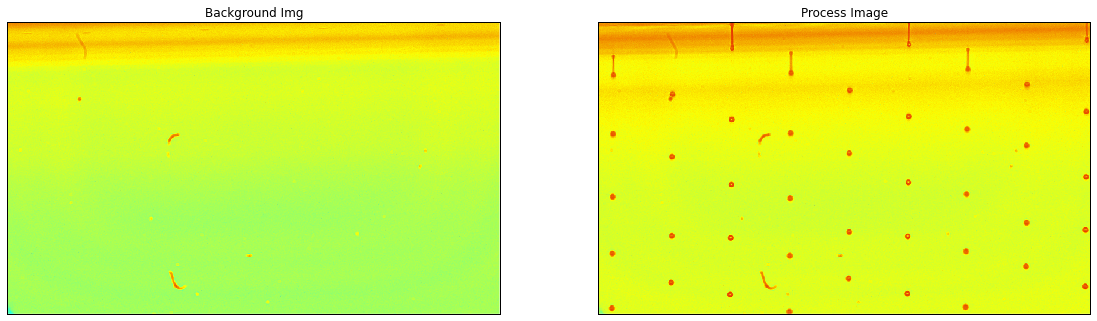

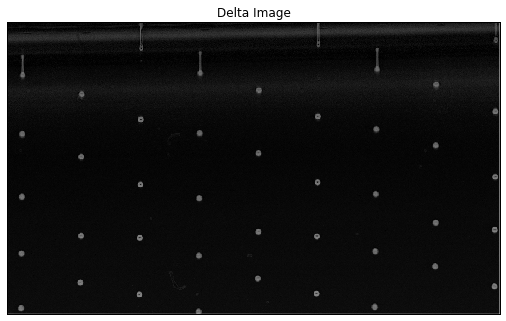

In [128]:
bg_img = cv2.imread('../images/dif/Properties_Reference/B00002.png', -1)
fg_img = cv2.imread('../images/dif/new light test 6 us_Cam_Date=160106_Time=164222/B00001.png', -1)
rows, cols, channels = bg_img.shape
print "Rows: ", rows, " Cols: ", cols

top = 200
bottom = 680
left = 0
right = 810
bg_img = bg_img[top:bottom, left:right]  #np slice: [startY:endY, startX:endX]
fg_img = fg_img[top:bottom, left:right]  #np slice: [startY:endY, startX:endX]

bg_img_gray = cv2.cvtColor(bg_img, cv2.COLOR_BGR2GRAY)
fg_img_gray = cv2.cvtColor(fg_img, cv2.COLOR_BGR2GRAY)

img_delta = cv2.absdiff(bg_img_gray, fg_img_gray)

util.plot_imgs([(bg_img, 'Background Img'), (fg_img, 'Process Image'), (img_delta, 'Delta Image')], max_cols=2, color=False)    

####...Not bad, put we may be able to do better if we use color channels individually.

###Test 2: Convert to HSV and separate into channels.

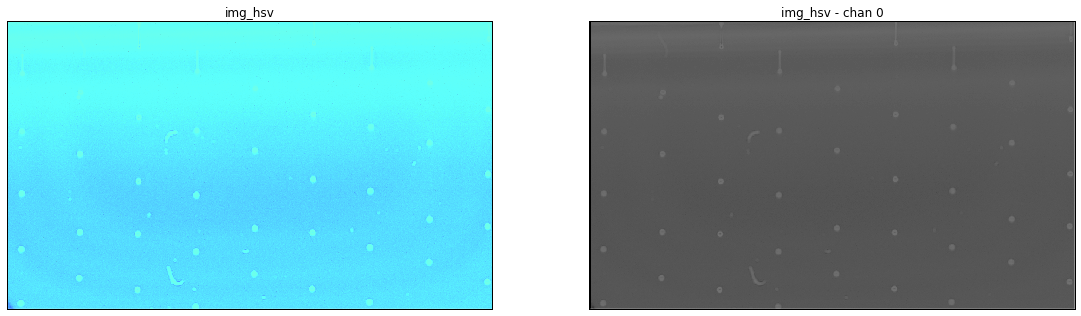

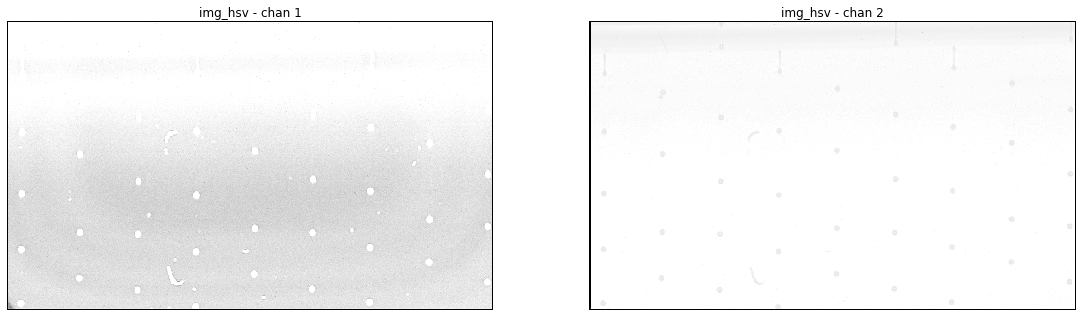

In [72]:
plot_lst = []
img_hsv = cv2.cvtColor(fg_img, cv2.COLOR_BGR2HSV)
plot_lst.append( (img_hsv, 'img_hsv') )

chan = ('0','1','2')
for chan_idx, chan in enumerate(chan):
    chan_img = cv2.split(img_hsv)[chan_idx]
    plot_lst.append( (chan_img, 'img_hsv - chan %d' % (chan_idx)) )
    
util.plot_imgs(plot_lst, max_cols=2)

####...Looks promising.  

###Find some diffs between channels...

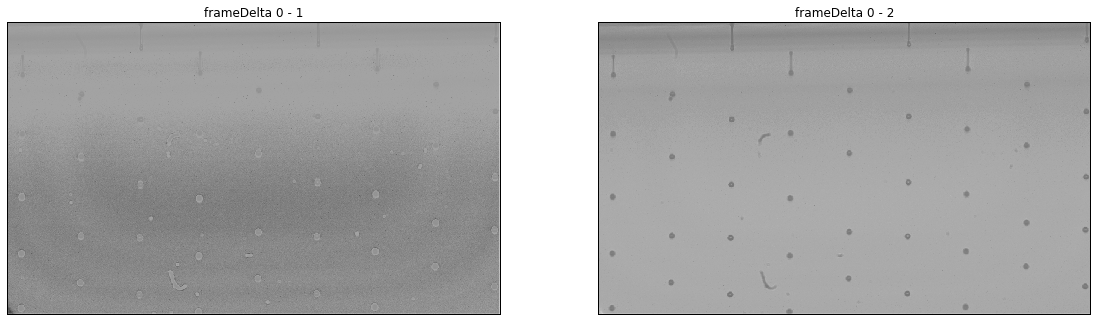

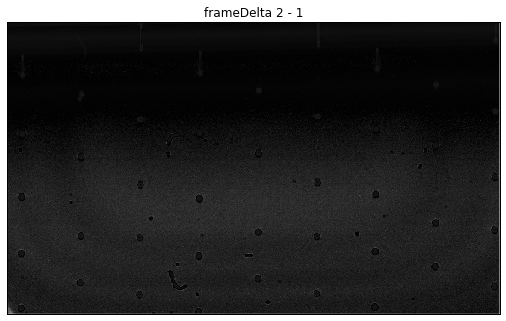

In [73]:
plot_lst = []
img_split = cv2.split(img_hsv)

frameDelta1 = cv2.absdiff(img_split[1], img_split[0])
plot_lst.append( (frameDelta1, 'frameDelta 0 - 1') )

frameDelta2 = cv2.absdiff(img_split[2], img_split[0])
plot_lst.append( (frameDelta2, 'frameDelta 0 - 2') )

frameDelta2 = cv2.absdiff(img_split[2], img_split[1])
plot_lst.append( (frameDelta2, 'frameDelta 2 - 1') )

util.plot_imgs(plot_lst, max_cols=2)

####The delta image from subtracting chan[0] and chan[2] seems to have the most information.  

###Test 3: Do the background subtraction again, but use the delta channel images
####Do the image subtraction using the delta images from the background and process images.  Apply threshold and gaussian filter too...

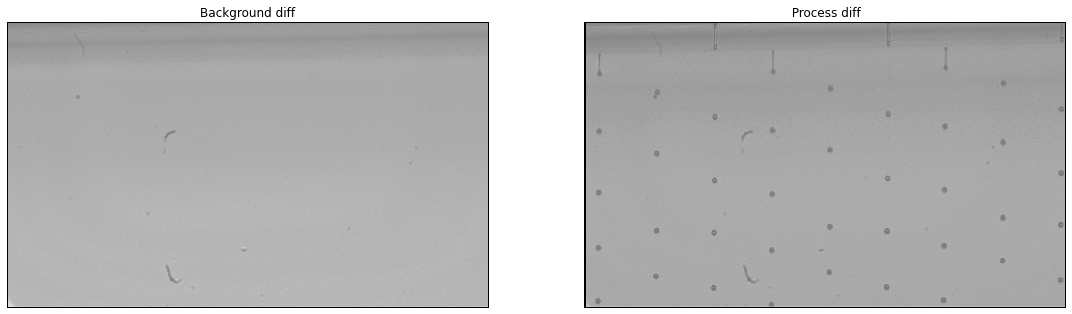

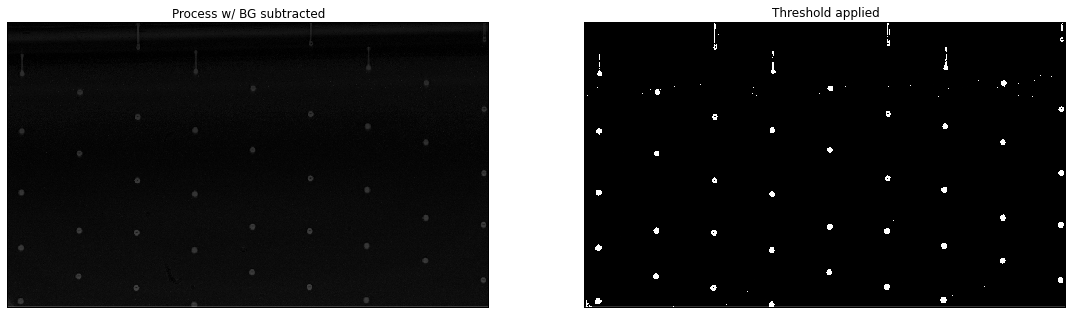

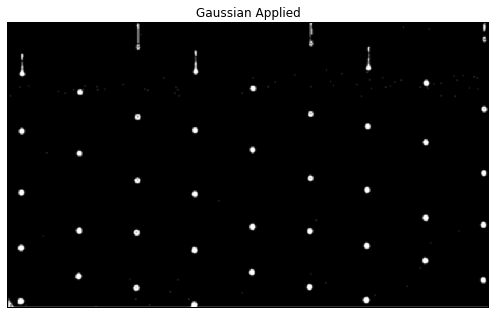

In [125]:
plot_lst = []

bg_img_hsv = cv2.cvtColor(bg_img, cv2.COLOR_BGR2HSV)
fg_img_hsv = cv2.cvtColor(fg_img, cv2.COLOR_BGR2HSV)

bg_img_hsv_split = cv2.split(bg_img_hsv)
fg_img_hsv_split = cv2.split(fg_img_hsv)

bg_img_diff = cv2.absdiff(bg_img_hsv_split[2], bg_img_hsv_split[0])
plot_lst.append( (bg_img_diff, 'Background diff') )

fg_img_diff = cv2.absdiff(fg_img_hsv_split[2], fg_img_hsv_split[0])
plot_lst.append( (fg_img_diff, ' Process diff') )

img_delta = cv2.absdiff(bg_img_diff, fg_img_diff)
plot_lst.append( (img_delta, 'Process w/ BG subtracted') )

thresh_val = 25
kernel_size = 5

ret,img_delta_thresh = cv2.threshold(img_delta, thresh_val, 255, cv2.THRESH_BINARY)
plot_lst.append( (img_delta_thresh,'Threshold applied') )

img_delta_thresh_blurred = cv2.GaussianBlur(img_delta_thresh, (kernel_size, kernel_size), 0)
plot_lst.append( (img_delta_thresh_blurred,'Gaussian Applied') )

util.plot_imgs(plot_lst, max_cols=2)

####Much better background subtraction...the dirt on the CCD/optics was removed entirely....

###Define callable function of above stack 

In [126]:
def preprocess_image(bg_img, fg_img, thresh_val, kernel_size):
    bg_img_hsv = cv2.cvtColor(bg_img, cv2.COLOR_BGR2HSV)
    fg_img_hsv = cv2.cvtColor(fg_img, cv2.COLOR_BGR2HSV)

    bg_img_hsv_split = cv2.split(bg_img_hsv)
    fg_img_hsv_split = cv2.split(fg_img_hsv)

    bg_img_diff = cv2.absdiff(bg_img_hsv_split[2], bg_img_hsv_split[0])
    fg_img_diff = cv2.absdiff(fg_img_hsv_split[2], fg_img_hsv_split[0])

    img_delta = cv2.absdiff(bg_img_diff, fg_img_diff)

    ret,img_delta_thresh = cv2.threshold(img_delta, thresh_val, 255, cv2.THRESH_BINARY)
    img_delta_thresh_blurred = cv2.GaussianBlur(img_delta_thresh, (kernel_size, kernel_size), 0)
    return img_delta_thresh_blurred

###Run the stack on folder of images.

####Using the function defined above to do HSV conversion, channel separation, channel delta, subtraction, threshold then finally gaussian, run pre-processed image through the Hough Circle function to try and find all the drops.  Finally, fit circles around the drops for each image, and print out the x, y, rad of circles.
#####Be patient! This cell takes a while to process...Scroll to the bottom for images...

Num imgs:  20
Image 0, Num drops found: 45
Image 1, Num drops found: 43
Image 2, Num drops found: 41
Image 3, Num drops found: 42
Image 4, Num drops found: 43
Image 5, Num drops found: 42
Image 6, Num drops found: 36
Image 7, Num drops found: 41
Image 8, Num drops found: 38
Image 9, Num drops found: 41

Plotting...please stand by...


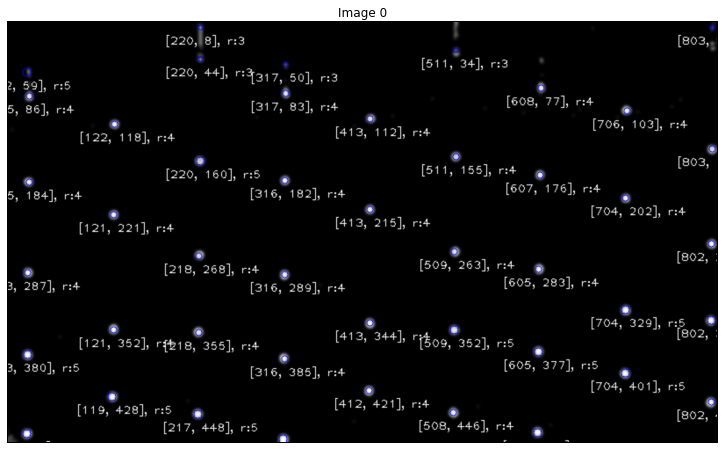

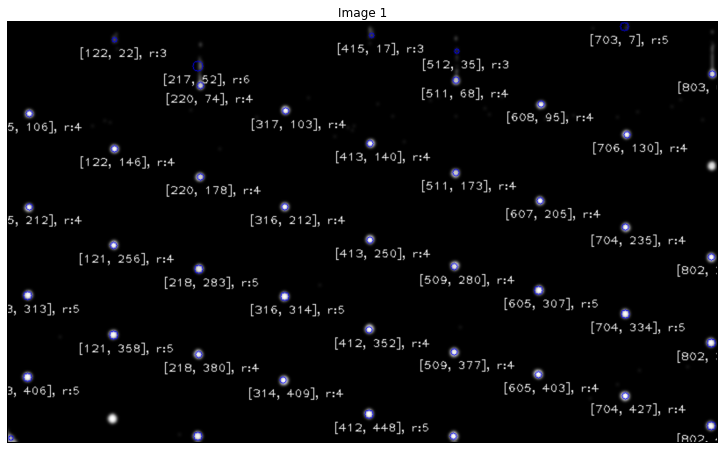

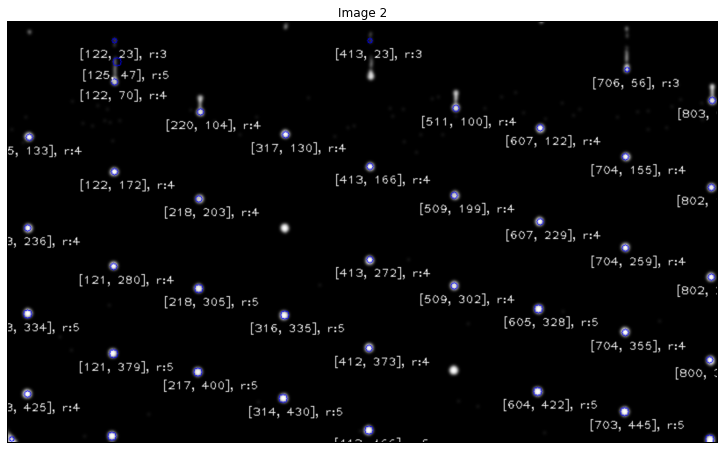

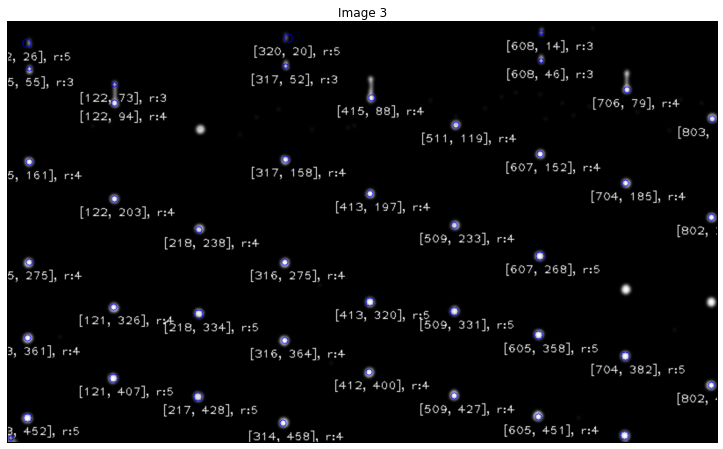

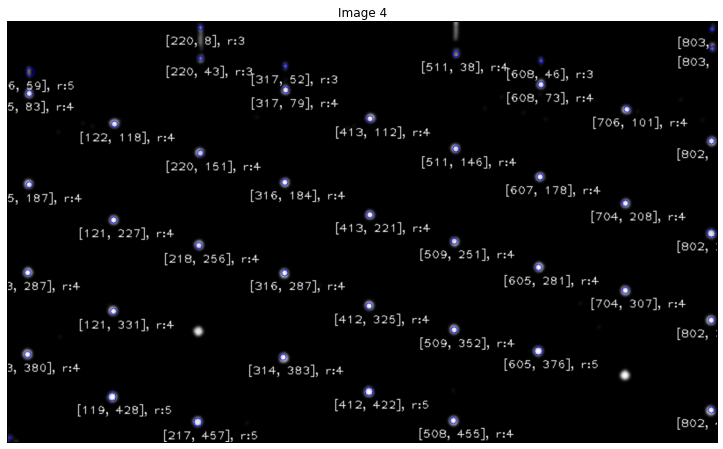

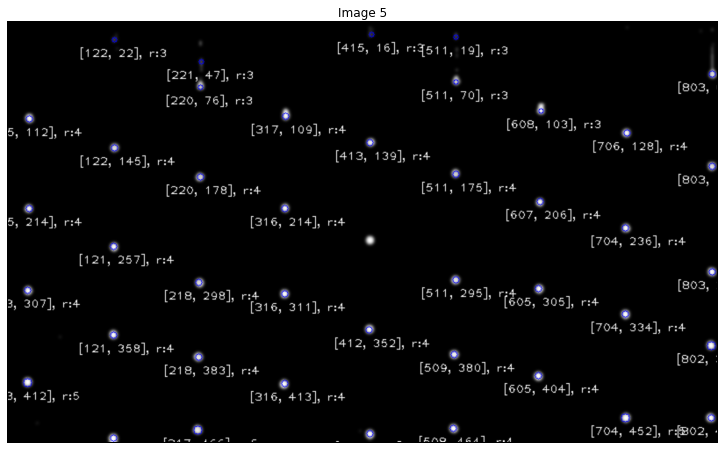

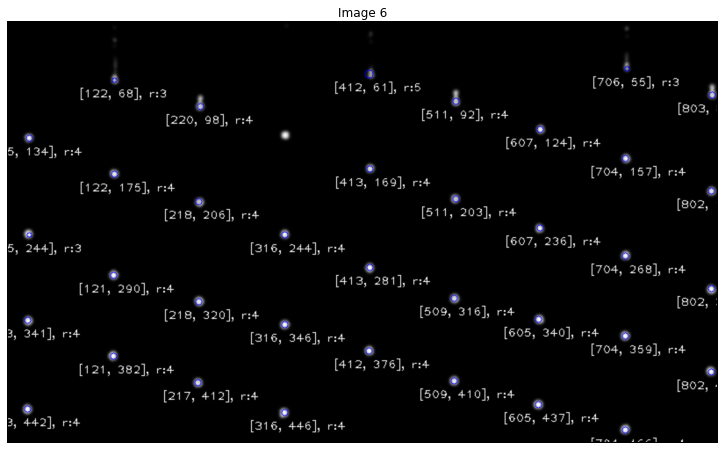

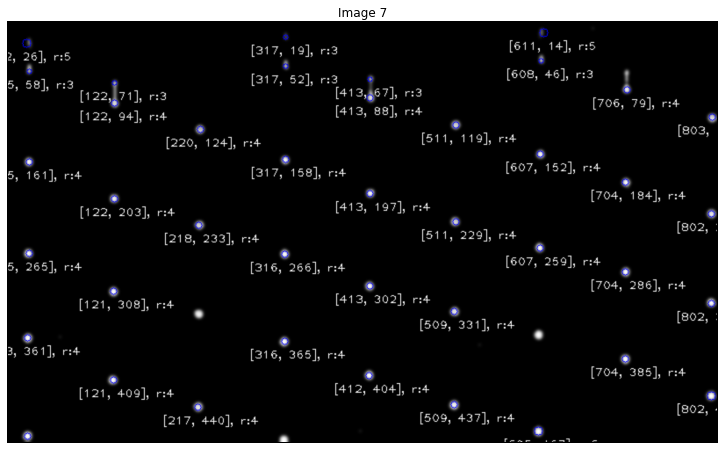

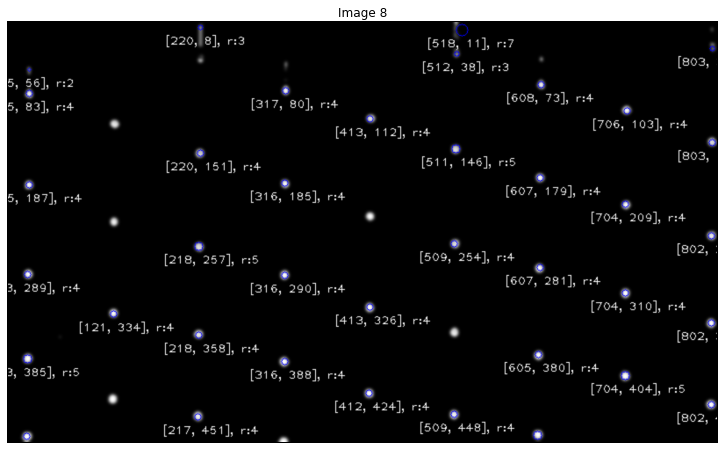

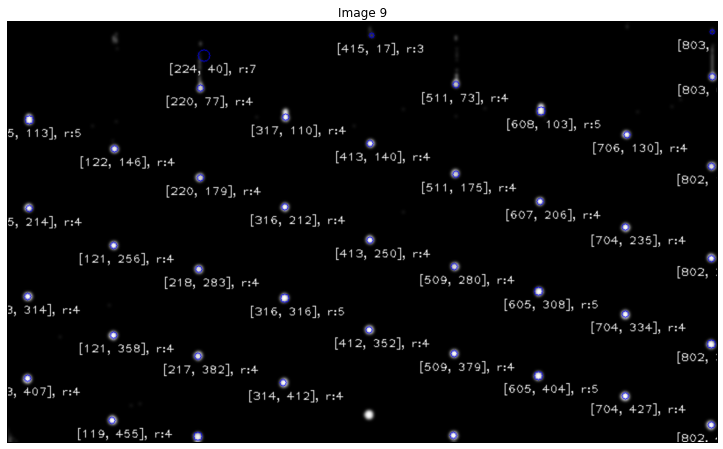

In [129]:
plot_lst = []
bg_img = cv2.imread('../images/dif/Properties_Reference/B00002.png', -1)

image_folder_lst = ['../images/dif/new light test 6 us_Cam_Date=160106_Time=164222']
file_spec = 'B*.png'
fg_img_lst = util.Image_List(image_folder_lst, file_spec, doSort=True, overlay=None, color=True)

print "Num imgs: ", fg_img_lst.cnt()

thresh_val = 30
kernel_size = 9
top = 200
bottom = 680
left = 0
right = 810

for idx, fg_img in enumerate(fg_img_lst.images[0:10]):
    img_delta_thresh_blurred = preprocess_image(bg_img[top:bottom, left:right], fg_img[top:bottom, left:right], thresh_val, kernel_size)

    #contour_img, contours, hierarchy = cv2.findContours(img_delta_thresh_blurred, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #plot_lst.append( (contour_img,'contour_img') )
    circles = cv2.HoughCircles(img_delta_thresh_blurred, cv2.HOUGH_GRADIENT, 1.5, 20,
                            param1=100,param2=10,minRadius=2,maxRadius=10)
    print("Image %d, Num drops found: %d" %(idx,len(circles[0,:])))
    
    cimg = cv2.cvtColor(img_delta_thresh_blurred,cv2.COLOR_GRAY2BGR)
    circles = np.uint16(np.around(circles))
    for idx2, i in enumerate(circles[0,:]):
        cv2.circle(cimg,(i[0],i[1]), i[2], util.blue, 1)
        #print(" [%02d-%02d] X: %03d, Y: %03d, Rad: %3.2f" % (idx, idx2, i[0],i[1],i[2]))
        cv2.putText(cimg, "[%d, %d], r:%d" % (i[0],i[1],i[2]), (i[0]-40,i[1]+20), 
                    cv2.FONT_HERSHEY_PLAIN, 0.9, util.white)        
    plot_lst.append( (cimg, 'Image %d' % (idx)) )

print("\nPlotting...please stand by...")
util.plot_imgs(plot_lst, max_cols=1, interp = 'bicubic', fig_size = 15)
